In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.7.0

In [3]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Add, Multiply, Reshape, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW
# from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.densenet import DenseNet121

In [4]:
# Load data
x_train = np.load('/content/drive/MyDrive/np_images/x_train.npy')
y_train = np.load('/content/drive/MyDrive/np_images/y_train.npy')
x_test = np.load('/content/drive/MyDrive/np_images/x_test.npy')
y_test = np.load('/content/drive/MyDrive/np_images/y_test.npy')

In [5]:
# Preprocess the data
x_train = tf.keras.applications.efficientnet.preprocess_input(x_train)
x_test = tf.keras.applications.efficientnet.preprocess_input(x_test)

In [6]:
def preprocess_image(img):
    # Crop the center 80% of the image
    height, width, channels = img.shape
    crop_height = int(height * 0.8)
    crop_width = int(width * 0.8)
    start_height = int((height - crop_height) / 2)
    start_width = int((width - crop_width) / 2)
    img = img[start_height:start_height+crop_height, start_width:start_width+crop_width, :]
    
    # Apply Gaussian blur with kernel size 3
    img = cv2.GaussianBlur(img, (3, 3), 0)

    img = cv2.resize(img, (224, 224))
    
    # Rescale the pixel values to [0, 1]
    img = img / 255.0
    
    return img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        # rotation_range=20 ,      # Degree range for random rotations
        # zoom_range=0.1
        preprocessing_function = preprocess_image
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train,batch_size=32)
print("Image data augmentated ...")

In [ ]:
# Split data into train and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)

In [12]:
import keras.backend as K
from tensorflow.keras.models import Model

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# ----------------------------------

# Create model
model = densenet_sa(num_classes=5)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy',f1])

history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)


Epoch 1/100
46/46 [==============================] - 139s 1s/step - loss: 0.6818 - accuracy: 0.7491 - f1: 0.4044 - val_loss: 1.0896 - val_accuracy: 0.5730 - val_f1: 0.1986
Epoch 2/100
46/46 [==============================] - 33s 713ms/step - loss: 0.3604 - accuracy: 0.8699 - f1: 0.6969 - val_loss: 0.7587 - val_accuracy: 0.7367 - val_f1: 0.3346
Epoch 3/100
46/46 [==============================] - 33s 717ms/step - loss: 0.1877 - accuracy: 0.9413 - f1: 0.8666 - val_loss: 0.7929 - val_accuracy: 0.7435 - val_f1: 0.3325
Epoch 4/100
46/46 [==============================] - 33s 711ms/step - loss: 0.0895 - accuracy: 0.9792 - f1: 0.9441 - val_loss: 0.7499 - val_accuracy: 0.7585 - val_f1: 0.3817
Epoch 5/100
46/46 [==============================] - 33s 716ms/step - loss: 0.0634 - accuracy: 0.9840 - f1: 0.9609 - val_loss: 0.8080 - val_accuracy: 0.7599 - val_f1: 0.3745
Epoch 6/100
46/46 [==============================] - 33s 716ms/step - loss: 0.0481 - accuracy: 0.9863 - f1: 0.9567 - val_loss: 1.055

In [13]:
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/Densenet_self_model/self_dense_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


model.save('/content/drive/MyDrive/Densenet_self_model/Densenet_self_model.h5')


In [15]:
import matplotlib as plt

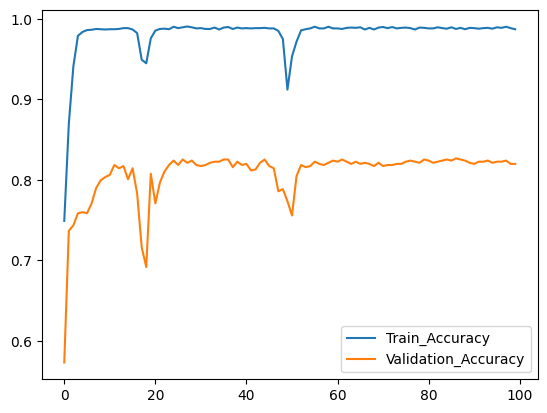

In [18]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])

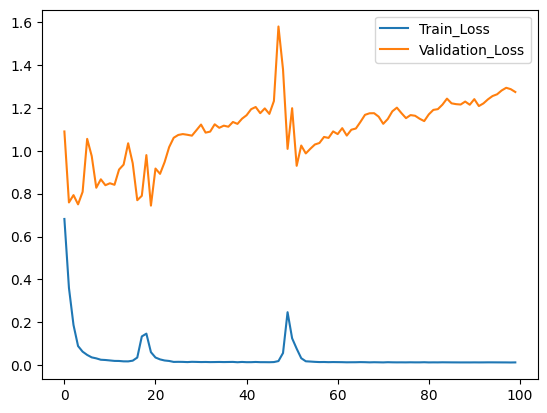

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

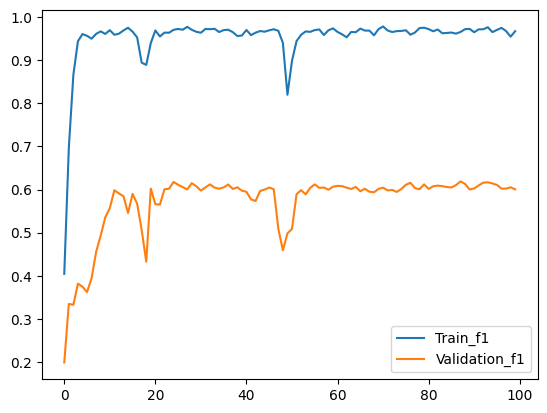

In [20]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['Train_f1','Validation_f1'])

In [22]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis = 1)
pred.shape

23/23 [==============================] - 2s 88ms/step


(733,)

In [27]:
import numpy as np

# Convert multilabel-indicator targets to multiclass labels
y_test = np.argmax(y_test, axis=1)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(pred, y_test)
print(cf_matrix)


[[345   8   5   0   0]
 [  5  34  12   0   3]
 [  1  26 179  16  25]
 [  0   0  12  14   8]
 [  0   0   5   6  29]]


<Axes: >

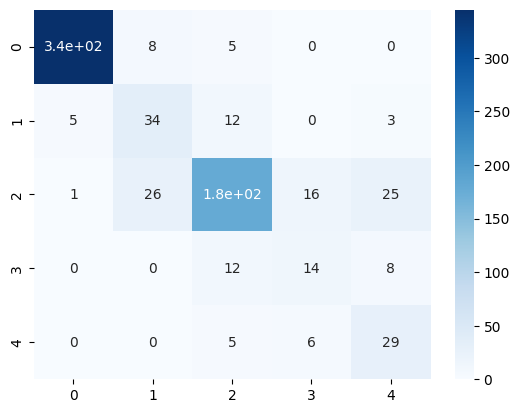

In [30]:
import seaborn as sns
sns.heatmap(cf_matrix, cmap='Blues', annot=True)

In [26]:
test_loss, test_acc, test_f1 = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)
print('Test F1 score:', test_f1)

23/23 [==============================] - 2s 91ms/step - loss: 1.2736 - accuracy: 0.8199 - f1: 0.6004
Test accuracy: 0.819918155670166
Test F1 score: 0.6003977656364441
